In [1]:
# general libraries
import pandas as pd
import pandas.testing as tm
import matplotlib.pyplot as plt
import numpy as np
import warnings
import os
import re
import seaborn as sns
from IPython.display import IFrame

# network analysis
import networkx as nx
from networkx.algorithms import bipartite

# text analysis
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
import sparse_dot_topn.sparse_dot_topn as ct
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# formatting commands
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font_scale=1.5)

/Users/dpong/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def component_size_one(G):
    '''Take a graph G and return a list of the 
       connected components of size 1 and the
       number of connected components of size 1'''
    components = [list(G) for G in nx.connected_components(G) if len(G) == 1]
    num_components = len(components)
    return components, num_components

# function to get large graph components
def giant_component_size(G):
    '''Take a graph G and return the largest connected component, 
        a list of the connected components > 1 and 
        the number of connected components > 1'''
    components = [(len(G), list(G)) for G in nx.connected_components(G) if len(G) > 1]
    num_components = len(components)
    GCC = [y[1] for y in components if y[0]
           == max([x[0] for x in components])][0]
    return GCC, components, num_components

# function to clean string
def clean_string(text):
    '''Take any text and return a cleaned version of the text
        without punctuation, lower cased, and removes stopwords'''
    text = ''.join([w for w in text if w not in string.punctuation])
    text = text.lower()
    text = ' '.join([w for w in text.split() if w not in stopwords])
    
    return text

# function to get the ngrams of a word or phrase
def ngrams(string, n=2):
    '''Takes any string removes characters, and creates
        ngrams of length n. Returns string and ngrams of
        string'''
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

# function to get the top n cosine similarity scores
def cos_sim_top(A, B, ntop, lower_bound=0):
    '''Takes any matrix A and B and returns the top n
        matching values with the higest cosine similarity
        score'''
    
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)
    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)
    return csr_matrix((data,indices,indptr),shape=(M,N))

# function to return the names that were run through the cossim_top function
def get_matches_df(sparse_matrix, name_vector, top=None):
    '''Takes any sparse matrix constructed from a name vector
        and returns the names and scores of values in the sparse
        matrix with a defned % cut off'''
    
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_side = np.empty([nr_matches], dtype=object)
    right_side = np.empty([nr_matches], dtype=object)
    similairity = np.zeros(nr_matches)
    
    for index in range(0, nr_matches):
        left_side[index] = name_vector[sparserows[index]]
        right_side[index] = name_vector[sparsecols[index]]
        similairity[index] = sparse_matrix.data[index]
    
    return pd.DataFrame({'left_side': left_side,
                          'right_side': right_side,
                           'similarity': similairity})

In [3]:
# loading listing data

listing_df = pd.read_csv('listings_hk.csv',dtype=object)
listing_df.rename(columns={'id':'listing_id'},inplace=True)
listing_df.shape

(6943, 74)

In [4]:
listing_df.head()

,listing_id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,69074,https://www.airbnb.com/rooms/69074,20210317193917,2021-03-19,Beautiful oasis of plants & art @ best location,An ideal Hong location any visitor--hip withou...,"In the upper part of trendy, hip Sheung Wan, w...",https://a0.muscache.com/pictures/84364564/1e0c...,160139,https://www.airbnb.com/users/show/160139,...,10,10,9,NaN,f,1,1,0,0,1.09
1,75083,https://www.airbnb.com/rooms/75083,20210317193917,2021-03-21,SoHo off Hollywood Road 3B,"Located steps from Hollywood road, with new ea...",NaN,https://a0.muscache.com/pictures/2873745/90c15...,304876,https://www.airbnb.com/users/show/304876,...,9,10,9,NaN,f,14,10,4,0,1.87
2,103760,https://www.airbnb.com/rooms/103760,20210317193917,2021-03-22,Central Centre 5 min walk to/from Central MTR,"Located right in the heart of Central, this 2 ...",NaN,https://a0.muscache.com/pictures/815221/056993...,304876,https://www.airbnb.com/users/show/304876,...,10,10,9,NaN,f,14,10,4,0,2.29
3,104626,https://www.airbnb.com/rooms/104626,20210317193917,2021-03-20,Entire Flat - Next to Man Mo Temple,<b>The space</b><br />Situated in one of Hong ...,NaN,https://a0.muscache.com/pictures/1947265/ef01a...,544166,https://www.airbnb.com/users/show/544166,...,10,10,9,NaN,f,1,1,0,0,0.12
4,132773,https://www.airbnb.com/rooms/132773,20210317193917,2021-03-22,Fabulous 2 Bdrm Aprt Open kitchen,"Nicely decorated, spacious 2 bedroom apartment...",The Sheung Wan neighbourhood is ever changing ...,https://a0.muscache.com/pictures/36936441/e4c1...,304876,https://www.airbnb.com/users/show/304876,...,10,10,10,NaN,f,14,10,4,0,1.76


In [18]:
# loading reviews data

reviews_df = pd.read_csv("reviews_hk.csv", dtype = object)
reviews_df.shape

(134415, 6)

In [19]:
# drop null comments from review data
reviews_df.dropna(inplace=True)
reviews_df.shape

(134290, 6)

In [20]:
# drop reviews containing 'This is an automated posting'
automated = reviews_df[reviews_df.comments.str.contains('This is an automated posting')].index
reviews_df.drop(index=automated, inplace=True)
reviews_df.shape

(133176, 6)

In [21]:
# reviews_df.listing_id.sort_values(ascending = True).unique()

In [22]:
# set up dataframes to merge
df_review = reviews_df[['listing_id', 'reviewer_id', 'reviewer_name', 'id', 'date', 'comments']].copy()
df_listing = listing_df[['listing_id', 'host_id', 'host_name']].copy()

# merge the dataframes
df_merged = pd.merge(df_review, df_listing, how='left', on='listing_id')
df_merged.shape

(133176, 8)

In [23]:
df_listing.shape

(6943, 3)

In [24]:
df_listing.head()

,listing_id,host_id,host_name
0,69074,160139,Amy
1,75083,304876,Brend
2,103760,304876,Brend
3,104626,544166,Celine
4,132773,304876,Brend


In [25]:
df_merged[df_merged.listing_id == "104626"]

,listing_id,reviewer_id,reviewer_name,id,date,comments,host_id,host_name
633,104626,704040,Winnie,380256,2011-07-18,Nice flat and convient place to stay. Very ...,544166,Celine
634,104626,797438,Ian,399111,2011-07-26,Excellent host - very prompt in replying to em...,544166,Celine
635,104626,961418,Daniel,542800,2011-09-18,It’s a lovely and cosy flat in a great locatio...,544166,Celine
636,104626,598589,Natasha,567678,2011-09-26,"Celine's flat is in a great location, is light...",544166,Celine
637,104626,1150340,Daryn & Alex,589941,2011-10-02,This was my first rental through AIRBNB and I ...,544166,Celine
638,104626,1212162,Luis,612269,2011-10-09,This is one of my favorite neighborhoods in HK...,544166,Celine
639,104626,1161859,Helge,686447,2011-11-02,We had a great time in HK and Celine’s place c...,544166,Celine
640,104626,1311899,Brandon,717584,2011-11-14,"Overall, Celine's flat was a great space to st...",544166,Celine
641,104626,1296753,Saidi,739710,2011-11-23,"Bonjour, mon séjour dans l'appartement de Céli...",544166,Celine
642,104626,879415,Christine,802901,2011-12-24,"As first timers in Hong Kong, we couldn't have...",544166,Celine


In [29]:
# checking for non-English comments
df = df_merged[df_merged.listing_id == "69074"]
pd.set_option('display.max_rows', df.shape[0]+1)
print(df)

    listing_id reviewer_id     reviewer_name         id        date  \
0        69074      358597           Chi Yan     181973  2011-02-14   
1        69074      467243            Doreen     252237  2011-05-05   
2        69074      696753           Michael     400484  2011-07-27   
3        69074       40901             Donna     411022  2011-08-01   
4        69074      341618           Melissa     497498  2011-09-03   
5        69074      544594               Lee     538628  2011-09-17   
6        69074      949163        Elisa & JP     554405  2011-09-21   
7        69074     1037045              Arun     569952  2011-09-26   
8        69074      748874           Jessica     619873  2011-10-11   
9        69074     1344180            Stefan     728812  2011-11-18   
10       69074     1254514             Titus     846293  2012-01-07   
11       69074      270862               Fa'     954044  2012-02-27   
12       69074     2287626          Jennifer    1449439  2012-06-10   
13    

In [30]:
# clean the merged dataframe
df_merged.dropna(inplace=True)
df_merged.drop_duplicates(subset=['id'], inplace=True)
df_merged.comments = df_merged.comments.map(lambda x: x.replace('\r', ''))
df_merged.reviewer_id = df_merged.reviewer_id.astype(int)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128516 entries, 0 to 133175
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   listing_id     128516 non-null  object
 1   reviewer_id    128516 non-null  int64 
 2   reviewer_name  128516 non-null  object
 3   id             128516 non-null  object
 4   date           128516 non-null  object
 5   comments       128516 non-null  object
 6   host_id        128516 non-null  object
 7   host_name      128516 non-null  object
dtypes: int64(1), object(7)
memory usage: 8.8+ MB


In [31]:
# calculate the number of reviews per hosts
host_review_counts = df_merged.groupby('host_id')[['id']].nunique().reset_index()
host_review_counts.rename(columns={'id': 'host_review_count'}, inplace=True)

# calculate reviews per reviewer
reviewer_review_counts = df_merged.groupby('reviewer_id')[['id']].nunique().reset_index()
reviewer_review_counts.rename(columns={'id': 'reviewer_review_count'}, inplace=True)

# calculate number of listings by host
host_listing_counts = df_merged.groupby('host_id')[['listing_id']].nunique().reset_index()
host_listing_counts.rename(columns={'listing_id': 'host_listing_counts'}, inplace=True)

# calculate number of hosts reviewed by reviewers
reviewer_host_counts = df_merged.groupby(['reviewer_id'])[['host_id']].nunique().reset_index()
reviewer_host_counts.rename(columns={'host_id': 'reviewer_host_counts'}, inplace=True)

In [32]:
df_merged_final = pd.merge(df_merged, host_review_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_review_counts, how='left', on='reviewer_id')
df_merged_final = pd.merge(df_merged_final, host_listing_counts, how='left', on='host_id')
df_merged_final = pd.merge(df_merged_final, reviewer_host_counts, how='left', on='reviewer_id')
df_merged_final.shape

(128516, 12)

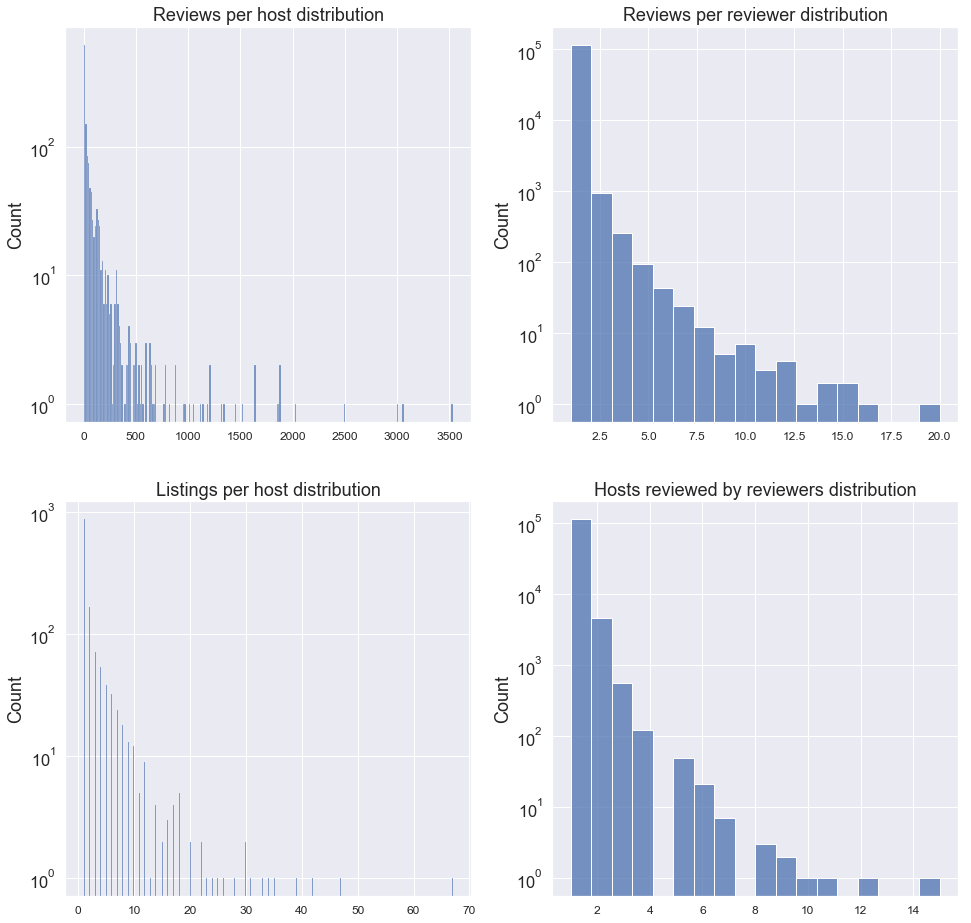

In [33]:
# plot histograms of host counts and reviewer counts
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(16, 16))
sns.histplot(host_review_counts.host_review_count, ax=ax[0,0])
sns.histplot(reviewer_review_counts.reviewer_review_count, ax=ax[0,1])
sns.histplot(host_listing_counts.host_listing_counts, ax=ax[1,0])
sns.histplot(reviewer_host_counts.reviewer_host_counts, ax=ax[1,1])
ax[0,0].set_title('Reviews per host distribution')
ax[0,1].set_title('Reviews per reviewer distribution')
ax[1,0].set_title('Listings per host distribution')
ax[1,1].set_title('Hosts reviewed by reviewers distribution')

for a in ax.flatten():
    a.set_xlabel('')
    a.tick_params(axis='x', labelsize=12, labelrotation=0)
    a.set_yscale('log')

plt.show()

In [34]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep=False)].copy()
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], keep=False, inplace=True)
subset.shape

(308, 12)

In [35]:
subset = df_merged_final[df_merged_final.duplicated(subset=['host_id', 'reviewer_id'], keep = False)].copy()
subset = subset[subset.host_listing_counts >= 5]
subset = subset[subset.reviewer_host_counts > 2]
subset.drop_duplicates(subset=['host_id', 'reviewer_id', 'listing_id', 'date'], inplace=True)
subset.shape

(308, 12)

In [36]:
print('Number of reviewers: ', len(subset.reviewer_id.unique()))
print('Number of hosts: ', len(subset.host_id.unique()))

Number of reviewers:  106
Number of hosts:  53


In [37]:
hosts = dict(subset[['host_id', 'host_name']].values)
reviewers = dict(subset[['reviewer_id', 'reviewer_name']].values)
labels_dict = {**reviewers, **hosts}

### Initial 2-Mode Network

In [38]:
subset.reviewer_id.nunique()

106

In [39]:
subset.host_id.nunique()

53

In [40]:
G = nx.Graph()
# Use bipartite 0 or 1 to denote which node it belongs to
G.add_nodes_from(subset.reviewer_id.unique(), bipartite=0)
G.add_nodes_from(subset.host_id.unique(), bipartite=1)
G.add_edges_from(subset[['reviewer_id', 'host_id']].values)

In [41]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 159
Number of edges: 119
Average degree:   1.4969


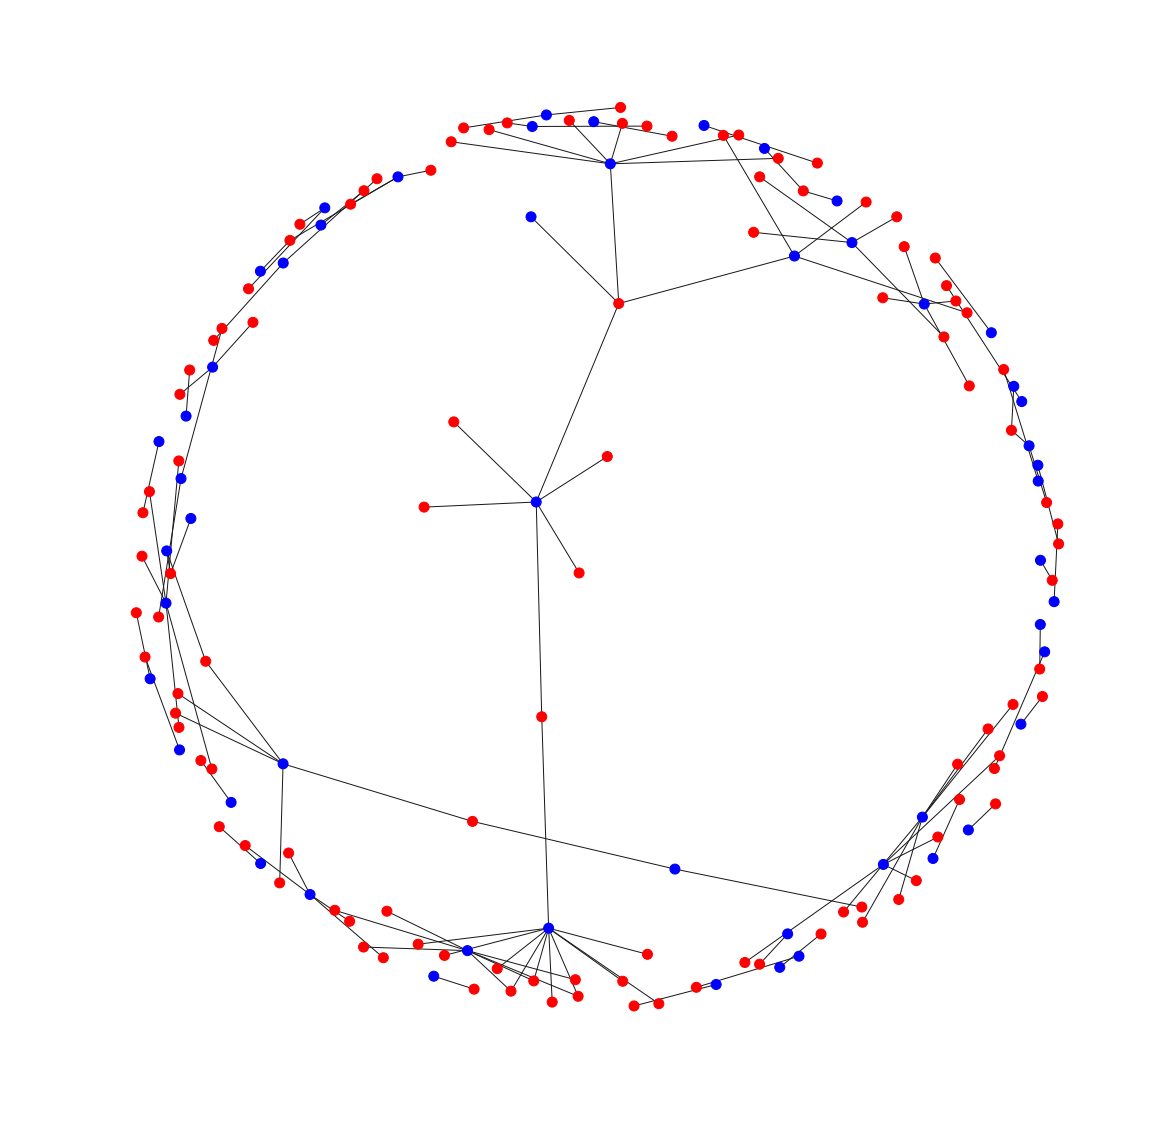

In [42]:
# nodes
reviewer_nodes = subset.reviewer_id.unique().tolist()
host_nodes = subset.host_id.unique().tolist()

# create plot
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G,iterations=35)
nx.draw_networkx_nodes(G, pos, node_size=100, node_color=['red']*len(reviewer_nodes) +
        ['blue']*(len(host_nodes)))
nx.draw_networkx_edges(G, pos, width=1)
plt.axis("off")
plt.show()

### Bipartite host graph

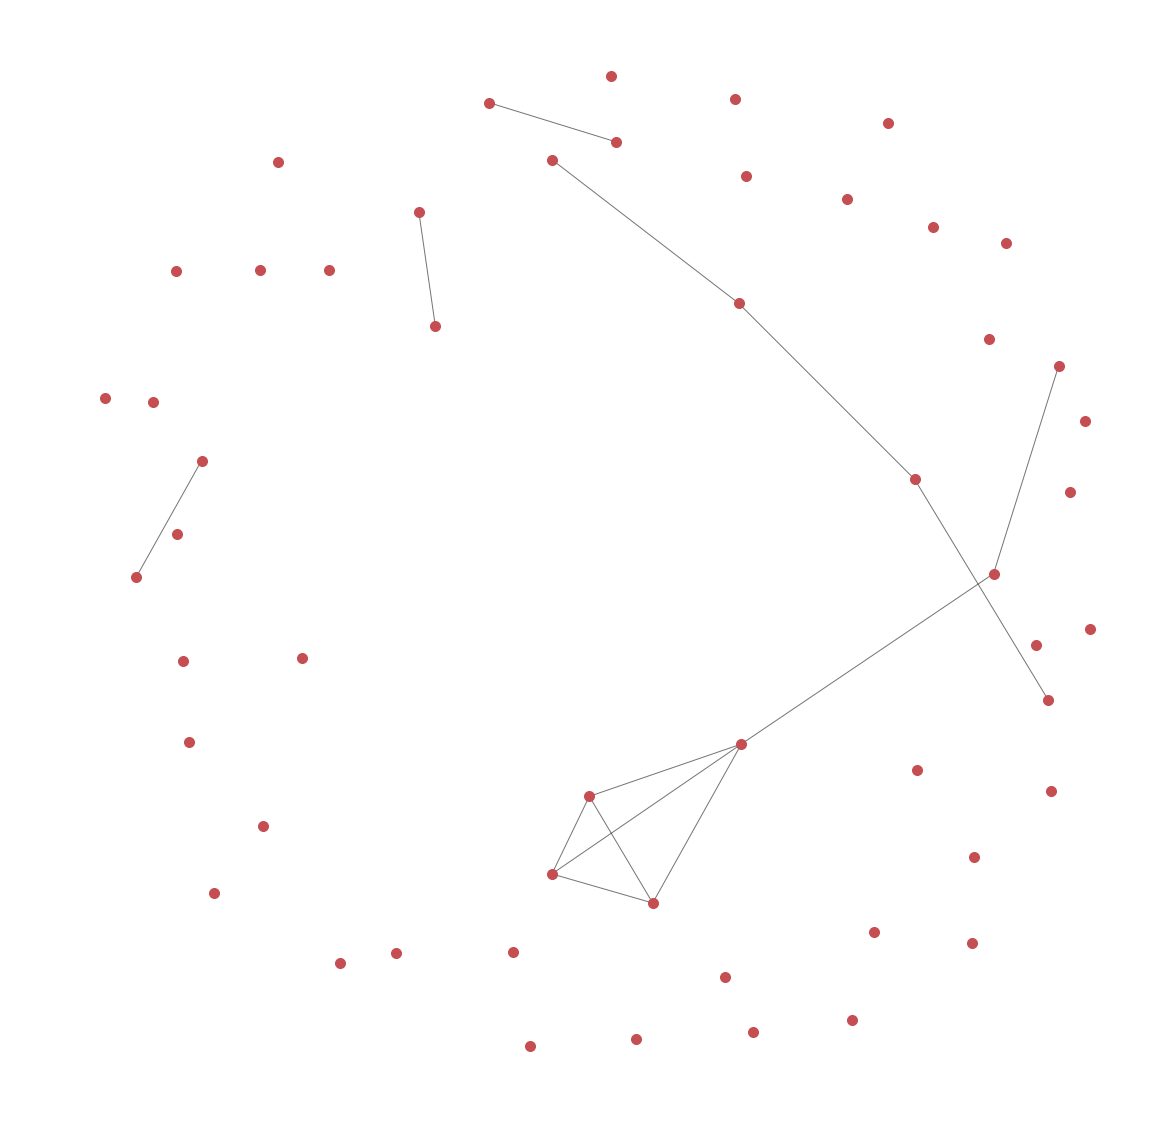

In [43]:
# look at projected graph (on hosts)
host_nodes = subset.host_id.unique().tolist()
B = bipartite.projected_graph(G, host_nodes)

pos = nx.spring_layout(B,iterations=15)
labels = {node: labels_dict[node] for node in B.nodes()}

# create plot
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(B, pos, node_size=100)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.6)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=10, font_family="sans-serif")
plt.axis("off")
plt.show()

In [44]:
# identify the components with no links
components_one, n_one = component_size_one(B)
components_one = [item for sublist in components_one for item in sublist]

print("Number of components:\n", n_one)

Number of components:
 37


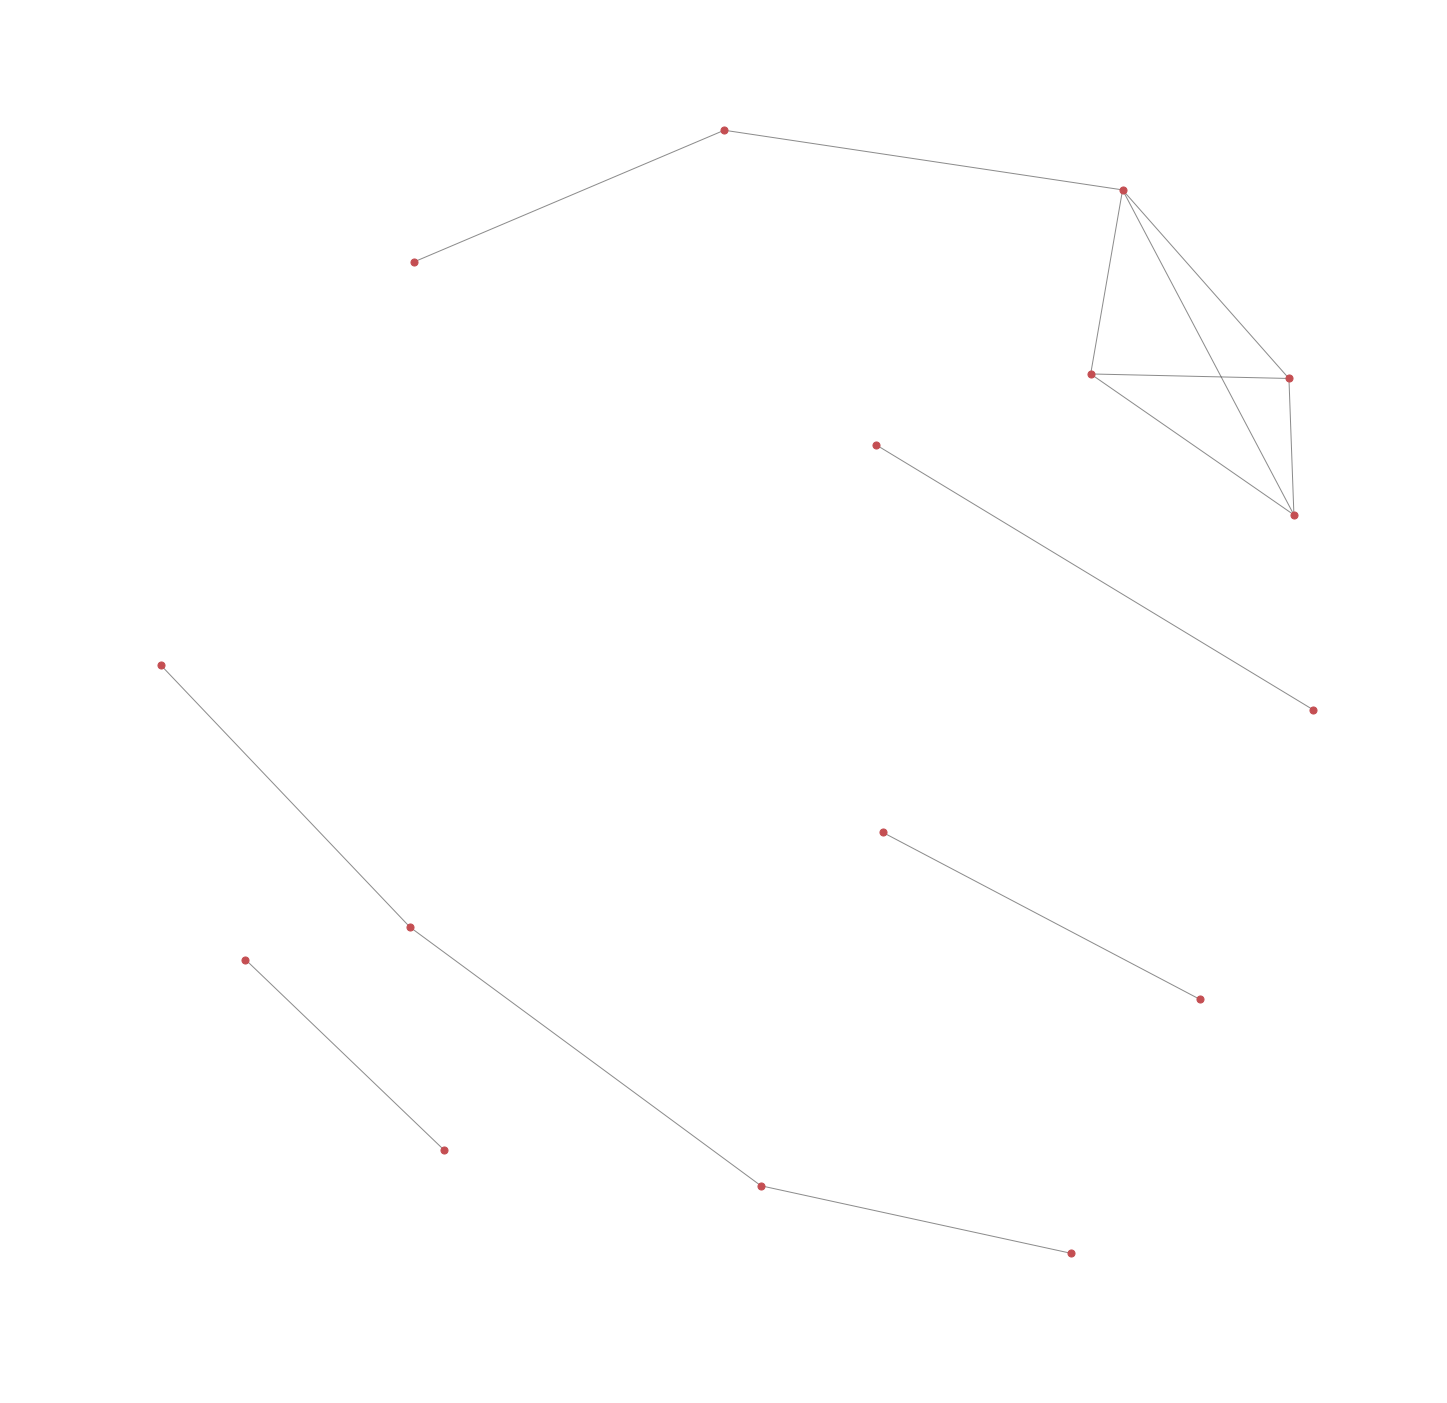

In [45]:
# remove the hosts with no links and plot the remaining ones
B.remove_nodes_from(components_one)

pos = nx.spring_layout(B,iterations=16)
labels = {node: labels_dict[node] for node in B.nodes()}

plt.figure(figsize=(25,25))
# nx.draw_networkx(B, pos, with_labels=False, node_size=100)
nx.draw_networkx_nodes(B, pos, node_size=50)
nx.draw_networkx_edges(B, pos, width=1,alpha=0.5)
# nx.draw_networkx_labels(B, pos, labels=labels, font_size=12, font_family="sans-serif")
plt.axis("off")
plt.show()